In [5]:
import re
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
log_root = "../runs/"

filenames = [os.path.basename(f) for f in glob.glob(os.path.join(log_root, "*"))]
print(filenames)

['2025-07-29:09-01-40']


In [7]:
setups = {}
for f in filenames:
    fq = os.path.join(log_root, f, "run.log")
    with open(fq, "r") as fr:
        s = fr.readlines()
        # get CLI params
        args_str = "\n".join(s[:100])
        manual_seed = re.search(r"manual_seed: (\d+)", args_str).group(1)
        knowledge_distillation = re.search(
            r"knowledge_distillation: (\w+)", args_str
        ).group(1)
        knowledge_distillation = "kd" if knowledge_distillation == "true" else "nokd"
        client_selection = re.search(r"client_selection: (\w+)", args_str).group(1)

        # get evaluation results
        eval_timeline = []
        eval_regex = r".*Server-side evaluation \(global round=(\d+)\) p=(\d\.\d+): loss=(\d+\.\d+) / accuracy=(\d+\.\d+)"
        for line in s:
            if re.match(eval_regex, line):
                global_round, p, loss, accuracy = re.match(eval_regex, line).groups()
                global_round, p, loss, accuracy = (
                    int(global_round),
                    float(p),
                    float(loss),
                    float(accuracy),
                )
                eval_timeline.append(
                    {
                        "global_round": global_round,
                        "p": p,
                        "loss": loss,
                        "accuracy": accuracy,
                    }
                )

        setups[
            f"{client_selection}_{knowledge_distillation}_{manual_seed}"
        ] = eval_timeline

In [8]:
dfs = []
for k, v in setups.items():
    df = pd.DataFrame(v)
    client_selection, kd, seed = k.split("_")
    df["kd"] = False if kd == "nokd" else True
    df["seed"] = seed
    df["client_selection"] = client_selection
    dfs.append(df)
df = pd.concat(dfs)
print(df.head())

   global_round    p      loss  accuracy     kd seed client_selection
0            10  0.2  2.265688    0.1596  False  123           random
1            10  0.4  2.276175    0.1605  False  123           random
2            10  0.6  2.255559    0.1681  False  123           random
3            10  0.8  2.291195    0.1824  False  123           random
4            10  1.0  2.340854    0.1713  False  123           random


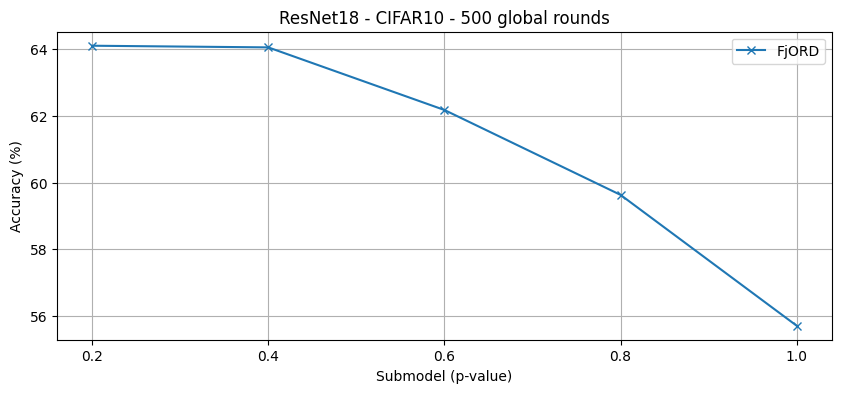

In [9]:
grouped_df = df.groupby(["kd", "global_round", "p"])
df_mean = grouped_df[["loss", "accuracy"]].mean()
df_std = grouped_df[["loss", "accuracy"]].std()

df_plot = df_mean.merge(
    df_std, left_index=True, right_index=True, suffixes=("_mean", "_std")
)
df_plot = df_plot.loc[:, 500, :]
grouped_df = df_plot.reset_index().groupby("kd")

plt.figure(figsize=(10, 4))
for i, (group_name, group_data) in enumerate(grouped_df):
    label = "FjORD w/ KD" if group_name else "FjORD"
    plt.plot(group_data.p, group_data.accuracy_mean * 100, label=label, marker="x")
    plt.fill_between(
        group_data.p,
        (group_data.accuracy_mean - group_data.accuracy_std) * 100,
        (group_data.accuracy_mean + group_data.accuracy_std) * 100,
        alpha=0.2,
    )

plt.legend()
plt.grid()
plt.title("ResNet18 - CIFAR10 - 500 global rounds")
plt.xlabel("Submodel (p-value)")
plt.ylabel("Accuracy (%)")
plt.xticks(np.linspace(0.2, 1, 5))

plt.savefig(
    "../_static/resnet18_cifar10_500_global_rounds_acc_pvalues.png",
    dpi=300,
    bbox_inches="tight",
)

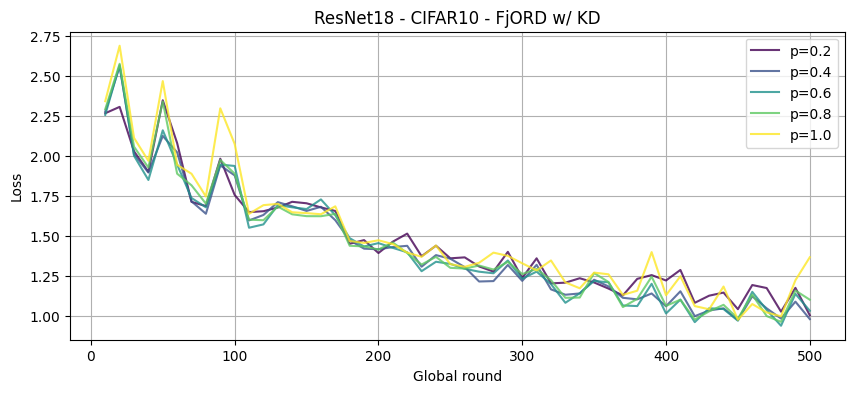

In [10]:
grouped_df = df.groupby(["kd", "global_round", "p"])
df_mean = grouped_df[["loss", "accuracy"]].mean()
df_std = grouped_df[["loss", "accuracy"]].std()

df_plot = df_mean.merge(
    df_std, left_index=True, right_index=True, suffixes=("_mean", "_std")
)
grouped_df = df_plot.reset_index().groupby(["kd"])

for i, (group_name, group_data) in enumerate(grouped_df):
    gd = group_data.groupby("p")
    plt.figure(figsize=(10, 4))
    title = "FjORD w/ KD" if bool(group_name) else "FjORD"
    filename_suffix = "fjord_kd" if bool(group_name) else "fjord"
    plt.title(f"ResNet18 - CIFAR10 - {title}")
    colors = plt.cm.viridis(np.linspace(0, 1, len(gd)))
    for j, (p, p_data) in enumerate(gd):
        plt.plot(
            p_data["global_round"],
            p_data["loss_mean"],
            color=colors[j],
            alpha=0.8,
            label=f"p={p}",
        )
        plt.fill_between(
            p_data["global_round"],
            p_data["loss_mean"] - p_data["loss_std"],
            p_data["loss_mean"] + p_data["loss_std"],
            alpha=0.1,
            color=colors[j],
        )
    plt.xlabel("Global round")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.savefig(
        f"../_static/resnet18_cifar10_{filename_suffix}_convergence.png",
        dpi=300,
        bbox_inches="tight",
    )